# Experiment 6: System Prompt Robustness

**Goal:** Test how robust system prompt effects are to paraphrasing and variations.

**Setup:**
- Fixed test prompts
- Same system prompt intent expressed differently
- Measure consistency of effects across paraphrases

In [3]:
# Setup path for imports
import sys
import os

# Handle both local and Colab environments
if 'google.colab' in sys.modules:
    # In Colab - go to repo root
    repo_root = '/content/LLM-Instruction-Understanding'
    if os.path.exists(repo_root):
        os.chdir(repo_root)
        if repo_root not in sys.path:
            sys.path.insert(0, repo_root)
else:
    # Local - add parent directory
    parent = os.path.abspath('..')
    if parent not in sys.path:
        sys.path.insert(0, parent)

print(f"Working directory: {os.getcwd()}")

Working directory: /content/LLM-Instruction-Understanding


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import re

from src.model_utils import load_model
from src.metrics import DistributionMetrics
from src.visualization import set_style
from src.test_configs import (
    TEST_PROMPTS, ALL_TEST_PROMPTS, SYSTEM_PROMPTS,
    build_chat_prompt, get_all_categories
)

set_style()

In [5]:
model = load_model("TinyLlama/TinyLlama-1.1B-Chat-v1.0")

Loading model: TinyLlama/TinyLlama-1.1B-Chat-v1.0


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Model loaded on cuda


## 1. Define Paraphrase Sets

In [6]:
# Same intent, different wording
PARAPHRASE_SETS = {
    "be_concise": [
        "Be concise.",
        "Keep it brief.",
        "Short answers only.",
        "Be as brief as possible.",
        "Respond concisely.",
        "Use few words.",
        "Keep responses short.",
    ],
    
    "be_helpful": [
        "Be helpful.",
        "Help the user.",
        "Provide helpful responses.",
        "Be as helpful as possible.",
        "Assist the user effectively.",
        "Give useful answers.",
        "Be a helpful assistant.",
    ],
    
    "be_accurate": [
        "Be accurate.",
        "Ensure accuracy.",
        "Provide accurate information.",
        "Be precise and correct.",
        "Give accurate answers.",
        "Accuracy is paramount.",
        "Make sure your answers are correct.",
    ],
    
    "think_step_by_step": [
        "Think step by step.",
        "Reason through this step by step.",
        "Work through this systematically.",
        "Break this down into steps.",
        "Analyze this step by step.",
        "Take it one step at a time.",
        "Proceed methodically.",
    ]
}

## 2. Measure Paraphrase Consistency

In [7]:
TEST_SUBSET = ALL_TEST_PROMPTS[:8]

def measure_paraphrase_consistency(model, test_prompts, paraphrase_sets):
    results = []
    
    for intent, paraphrases in tqdm(paraphrase_sets.items()):
        for test in test_prompts:
            # Get distribution for each paraphrase
            distributions = []
            for para in paraphrases:
                prompt = build_chat_prompt(para, test["prompt"], model.tokenizer)
                dist = model.get_next_token_distribution(prompt, top_k=50)
                distributions.append({
                    "paraphrase": para,
                    "full_probs": dist["full_probs"],
                    "entropy": dist["entropy"],
                    "top_token": dist["top_tokens"][0]
                })
            
            # Calculate pairwise JS divergences
            js_values = []
            for i in range(len(distributions)):
                for j in range(i+1, len(distributions)):
                    js = DistributionMetrics.jensen_shannon(
                        distributions[i]["full_probs"],
                        distributions[j]["full_probs"]
                    )
                    js_values.append(js)
            
            # Check top token consistency
            top_tokens = [d["top_token"] for d in distributions]
            top_token_consistency = len(set(top_tokens)) == 1
            
            results.append({
                "intent": intent,
                "test_id": test["id"],
                "category": test["category"],
                "mean_js": np.mean(js_values),
                "max_js": np.max(js_values),
                "entropy_std": np.std([d["entropy"] for d in distributions]),
                "top_token_consistent": top_token_consistency,
                "n_unique_top_tokens": len(set(top_tokens))
            })
    
    return pd.DataFrame(results)

consistency_df = measure_paraphrase_consistency(model, TEST_SUBSET, PARAPHRASE_SETS)

  0%|          | 0/4 [00:00<?, ?it/s]

## 3. Analyze Consistency

In [8]:
# Consistency by intent
intent_consistency = consistency_df.groupby('intent').agg({
    'mean_js': ['mean', 'std'],
    'top_token_consistent': 'mean',
    'n_unique_top_tokens': 'mean'
}).round(4)

intent_consistency.columns = ['js_mean', 'js_std', 'token_consistency', 'n_unique_tokens']
intent_consistency = intent_consistency.sort_values('js_mean')

print("=== Paraphrase Robustness by Intent ===")
print("Lower JS = more robust to paraphrasing")
print(intent_consistency)

=== Paraphrase Robustness by Intent ===
Lower JS = more robust to paraphrasing
                    js_mean  js_std  token_consistency  n_unique_tokens
intent                                                                 
be_accurate             inf     NaN                0.0            7.000
be_concise              inf     NaN                0.0            6.875
be_helpful              inf     NaN                0.0            6.875
think_step_by_step      inf     NaN                0.0            7.000


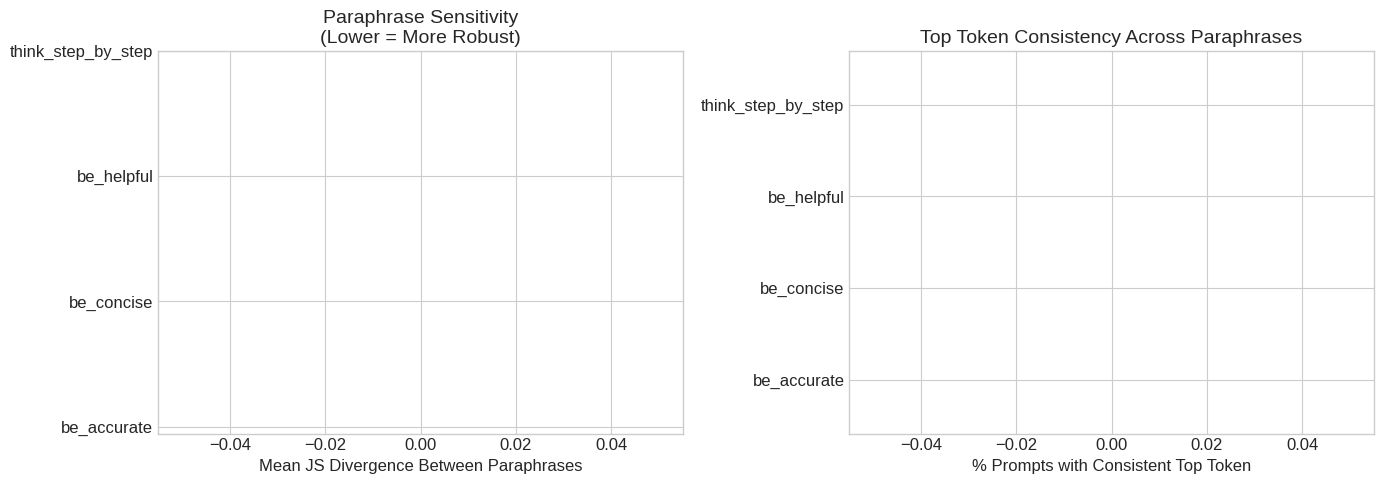

In [9]:
import os
os.makedirs('../results', exist_ok=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# JS divergence between paraphrases
ax = axes[0]
data = intent_consistency['js_mean']
colors = plt.cm.RdYlGn_r(data / data.max())
ax.barh(range(len(data)), data.values, xerr=intent_consistency['js_std'], color=colors, capsize=3)
ax.set_yticks(range(len(data)))
ax.set_yticklabels(data.index)
ax.set_xlabel('Mean JS Divergence Between Paraphrases')
ax.set_title('Paraphrase Sensitivity\n(Lower = More Robust)')

# Top token consistency
ax = axes[1]
data = intent_consistency['token_consistency'] * 100
ax.barh(range(len(data)), data.values, alpha=0.7)
ax.set_yticks(range(len(data)))
ax.set_yticklabels(data.index)
ax.set_xlabel('% Prompts with Consistent Top Token')
ax.set_title('Top Token Consistency Across Paraphrases')

plt.tight_layout()
plt.savefig('../results/exp6_robustness.png', dpi=150)
plt.show()

## 4. Identify Sensitive Paraphrases

In [10]:
# For each intent, find which paraphrases cause most divergence
print("=== Most Divergent Paraphrase Pairs ===")

for intent, paraphrases in PARAPHRASE_SETS.items():
    # Sample one test
    test = TEST_SUBSET[0]
    
    # Get all distributions
    dists = []
    for para in paraphrases:
        prompt = build_chat_prompt(para, test["prompt"], model.tokenizer)
        dist = model.get_next_token_distribution(prompt, top_k=50)
        dists.append((para, dist["full_probs"]))
    
    # Find max divergent pair
    max_js = 0
    max_pair = None
    for i in range(len(dists)):
        for j in range(i+1, len(dists)):
            js = DistributionMetrics.jensen_shannon(dists[i][1], dists[j][1])
            if js > max_js:
                max_js = js
                max_pair = (dists[i][0], dists[j][0])
    
    print(f"\n{intent}:")
    print(f"  Max JS: {max_js:.4f}")
    if max_pair:
        print(f"  '{max_pair[0]}' vs '{max_pair[1]}'")

=== Most Divergent Paraphrase Pairs ===

be_concise:
  Max JS: inf
  'Be concise.' vs 'Keep it brief.'

be_helpful:
  Max JS: inf
  'Be helpful.' vs 'Help the user.'

be_accurate:
  Max JS: inf
  'Be accurate.' vs 'Ensure accuracy.'

think_step_by_step:
  Max JS: inf
  'Think step by step.' vs 'Reason through this step by step.'


In [11]:
print("\n=== Summary ===")
most_robust = intent_consistency['js_mean'].idxmin()
least_robust = intent_consistency['js_mean'].idxmax()
print(f"Most robust intent: {most_robust}")
print(f"Least robust intent: {least_robust}")
print(f"\nImplication: '{least_robust}' instructions are sensitive to exact wording")


=== Summary ===
Most robust intent: be_accurate
Least robust intent: be_accurate

Implication: 'be_accurate' instructions are sensitive to exact wording


In [12]:
import json
with open('../results/exp6_results.json', 'w') as f:
    json.dump({"intent_consistency": intent_consistency.to_dict()}, f, indent=2, default=float)
print("Saved.")

Saved.
